<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#클래스-활성화에-대한-히트맵을-이미지에-시각화(CAM)" data-toc-modified-id="클래스-활성화에-대한-히트맵을-이미지에-시각화(CAM)-1">클래스 활성화에 대한 히트맵을 이미지에 시각화(CAM)</a></span></li></ul></div>

# 클래스 활성화에 대한 히트맵을 이미지에 시각화(CAM)

In [26]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from keras.applications.vgg16 import VGG16

In [27]:
model = VGG16(weights='imagenet')


In [28]:
## 이미지 전처리
from keras.preprocessing import image
from keras. applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = './cats_dogs/datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x_show = x / 255.
x = preprocess_input(x)

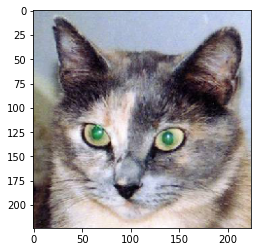

In [29]:
import matplotlib.pyplot as plt

plt.imshow(x_show[0])
plt.show()

In [30]:
preds = model.predict(x)
print('Preds: ', decode_predictions(preds, top=3)[0])
np.argmax(preds[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Preds:  [('n02124075', 'Egyptian_cat', 0.52406013), ('n02119789', 'kit_fox', 0.17562321), ('n02120505', 'grey_fox', 0.062272117)]


285

In [31]:
## Grad-CAM
from keras import backend as K

cat_output = model.output[:, 285]

last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(cat_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1,2))

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_ouput_value = iterate([x])

for i in range(512):
    conv_layer_ouput_value[:,:,i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_ouput_value, axis=-1)

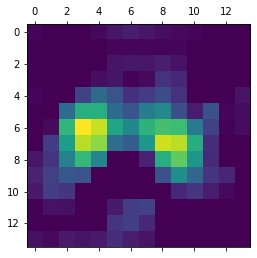

In [32]:
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [38]:
## 원본 이미지에 히트맵 덧붙이기
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

cv2.imwrite('./cats_dogs/datasets/cat_cam.jpg', superimposed_img)

True